使用ResNet50对CelebA数据集进行分类
===

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# 1.全局设置

In [2]:
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 128*128
NUM_CLASSES = 2
BATCH_SIZE = 128*torch.cuda.device_count()
DEVICE = 'cuda:0' # default GPU device
GRAYSCALE = False
DATA_ROOT = os.path.join("/input", "face")
IMAGE_ROOT = os.path.join(DATA_ROOT, "img_align_celeba")

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

(218, 178, 3)


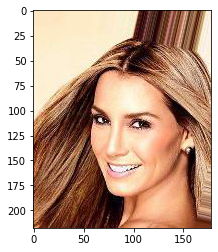

In [4]:
img = Image.open(os.path.join(IMAGE_ROOT, '000001.jpg'))
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

# 2.导入数据

In [5]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = CelebaDataset(csv_path='data/celeba-gender-train.csv',
                              img_dir=IMAGE_ROOT,
                              transform=custom_transform)

valid_dataset = CelebaDataset(csv_path='data/celeba-gender-valid.csv',
                              img_dir=IMAGE_ROOT,
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='data/celeba-gender-test.csv',
                             img_dir=IMAGE_ROOT,
                             transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

# 3.模型

In [6]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

def resnet50(num_classes, grayscale):
    """Constructs a ResNet-50 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=grayscale)
    return model
torch.manual_seed(RANDOM_SEED)

##########################
### COST AND OPTIMIZER
##########################

model = resnet50(NUM_CLASSES, GRAYSCALE)


#### DATA PARALLEL START ####
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)
#### DATA PARALLEL END ####


model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

# 4.训练

In [7]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Valid: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE),
              compute_accuracy(model, valid_loader, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/1272 | Cost: 0.6989
Epoch: 001/010 | Batch 0050/1272 | Cost: 0.4261
Epoch: 001/010 | Batch 0100/1272 | Cost: 0.1482
Epoch: 001/010 | Batch 0150/1272 | Cost: 0.1131
Epoch: 001/010 | Batch 0200/1272 | Cost: 0.1481
Epoch: 001/010 | Batch 0250/1272 | Cost: 0.1755
Epoch: 001/010 | Batch 0300/1272 | Cost: 0.2563
Epoch: 001/010 | Batch 0350/1272 | Cost: 0.1823
Epoch: 001/010 | Batch 0400/1272 | Cost: 0.1913
Epoch: 001/010 | Batch 0450/1272 | Cost: 0.2197
Epoch: 001/010 | Batch 0500/1272 | Cost: 0.0914
Epoch: 001/010 | Batch 0550/1272 | Cost: 0.0649
Epoch: 001/010 | Batch 0600/1272 | Cost: 0.1732
Epoch: 001/010 | Batch 0650/1272 | Cost: 0.1572
Epoch: 001/010 | Batch 0700/1272 | Cost: 0.0780
Epoch: 001/010 | Batch 0750/1272 | Cost: 0.1923
Epoch: 001/010 | Batch 0800/1272 | Cost: 0.1811
Epoch: 001/010 | Batch 0850/1272 | Cost: 0.1951
Epoch: 001/010 | Batch 0900/1272 | Cost: 0.1210
Epoch: 001/010 | Batch 0950/1272 | Cost: 0.2149
Epoch: 001/010 | Batch 1000/1272 | Cost:

Epoch: 007/010 | Batch 0300/1272 | Cost: 0.0573
Epoch: 007/010 | Batch 0350/1272 | Cost: 0.0158
Epoch: 007/010 | Batch 0400/1272 | Cost: 0.0377
Epoch: 007/010 | Batch 0450/1272 | Cost: 0.0237
Epoch: 007/010 | Batch 0500/1272 | Cost: 0.0311
Epoch: 007/010 | Batch 0550/1272 | Cost: 0.0340
Epoch: 007/010 | Batch 0600/1272 | Cost: 0.0250
Epoch: 007/010 | Batch 0650/1272 | Cost: 0.0198
Epoch: 007/010 | Batch 0700/1272 | Cost: 0.0231
Epoch: 007/010 | Batch 0750/1272 | Cost: 0.0792
Epoch: 007/010 | Batch 0800/1272 | Cost: 0.0506
Epoch: 007/010 | Batch 0850/1272 | Cost: 0.0356
Epoch: 007/010 | Batch 0900/1272 | Cost: 0.0549
Epoch: 007/010 | Batch 0950/1272 | Cost: 0.0665
Epoch: 007/010 | Batch 1000/1272 | Cost: 0.0266
Epoch: 007/010 | Batch 1050/1272 | Cost: 0.0768
Epoch: 007/010 | Batch 1100/1272 | Cost: 0.0283
Epoch: 007/010 | Batch 1150/1272 | Cost: 0.0400
Epoch: 007/010 | Batch 1200/1272 | Cost: 0.0133
Epoch: 007/010 | Batch 1250/1272 | Cost: 0.0217
Epoch: 007/010 | Train: 98.041% | Valid:

# 5.评估

In [8]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 96.97%


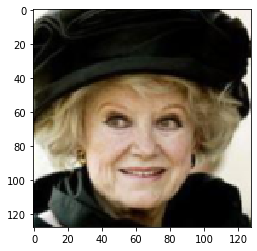

In [9]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [10]:
model.eval()
logits, probas = model(features.to(DEVICE)[0, None])
print('Probability Female %.2f%%' % (probas[0][0]*100))

Probability Female 99.95%
